# ML/NLP data scientist take-home exercise


The 2019 coronavirus disease (COVID-19, https://en.wikipedia.org/wiki/Coronavirus_disease_2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease has spread globally, resulting in the 2019–20 coronavirus pandemic.
 
Research into a solution for this problem is at full steam and, so far, more than 2000 research papers related to this have been published. As this number grows, keeping track of what is happening, recent results, etc., is becoming harder and harder. This is where modern advances in AI, ML and NLP are called for coming into action.

## Your task
 
Your mission is to create a report or dashboard that can be used by decision-makers and researchers to know what science results are being produced.
 
## Data
 
Many institutions and organizations, like the World Health Organization (WHO, https://www.who.int), or the Center for Disease Control and Prevention (CDC, https://www.cdc.gov) are gathering data and information related to the pandemic.
 
One of these organizations is the MIDAS Coordination Center (https://midasnetwork.us/mcc/). They are actively compiling and sharing information through the GitHub repository https://github.com/midas-network/COVID-19. In particular, they are sharing an export their Mendeley paper collection as XML files in  
https://github.com/midas-network/COVID-19/tree/master/documents/mendeley_library_files/xml_files
 
**Note:** You are expected to use the latest XML as the source of documents but you are free to cross the information stored here with other freely available on the web.

## Tasks
 
Given a list of papers create a report with the results of:
 
1. Read the most recent MIDAS Mendeley paper library XML file.
2. Generate groups of similar papers and assign a meaningful label or group of tags to each group.
3. Outline what papers inside each group better represent that group.
4. For each paper, provide a brief "one-liner" description of what the paper's main idea is.
5. Identify papers that represent potential breakthroughs

## Task 1

Read the most recent MIDAS Mendeley paper library XML file. You are expected to use the latest XML as the source of documents but you are free to cross the information stored here with other freely available on the web.

In [1]:
import xml.etree.ElementTree as ET
import requests

url = 'https://raw.githubusercontent.com/midas-network/COVID-19/master/documents/mendeley_library_files/xml_files/mendeley_document_library_2020-03-25.xml'
document = ET.fromstring(requests.get(url).text)

The xml files contains information such as title, authors, periodical, publisher, doi, ... and abstract that can be used for the purpose of grouping similar documents. Since we are not dealing with a large file and to facilitate the process in this exercise, I decided to convert the information into tabular format.

Most of the records in this selection are accompanied with a doi number that can be used to validate the content of the xml file and retrieve more information about the publication. For this purpose I am using the crossref api to validate the title and author along with a publication timestamp. One can use the title, authors, etc. in case the doi is not sufficient.

In [2]:
import requests, json
from tqdm.notebook import tqdm
import re


data = []

for record in tqdm(document.find('records').findall('record')):
    # retrieve information from the xml file
    
    title = record.find('./titles/title').text
    
    authors = [author.text for author in record.findall('./contributors/authors/author')]
    keywords = [keyword.text for keyword in record.findall('./keywords/keyword')]
    abstract = record.find('./abstract')
    abstract = abstract.text if abstract != None else ''
    doi = record.find('./electronic-resource-num')
    doi = doi.text if doi != None else ''
    
    if abstract == '':
        continue
    
    # cross publication using crossref api
    title_doi = ''
    publisher = ''
    container = ''
    published = ''
    authors_doi = []
    affiliations = []
    url = ''
    language = ''
    subject = []
    html = ''
    
    
    if doi != '' and '/' in doi:
        num, text = doi.split('/', maxsplit=1)        
        try:
            html = requests.get("https://api.crossref.org/v1/works/http://dx.doi.org/{0}/{1}".format(num, text)).text
        except requests.ConnectionError:
            html = ''
            print('Failed on doi', doi)

    if '503 Service Unavailable' in html or \
        html == 'Resource not found.' or \
        html == '' or json.loads(html)['status'] == 'failed':
        print('Failed on retrieve', html)
    else:                 
        data_json = json.loads(html)['message']

        title_doi = data_json['title'][0] if 'title' in data_json else ''
        publisher = data_json['publisher'] if 'publisher' in data_json else ''
        container = data_json['container-title'] if 'container-title' in data_json else ''
        published = data_json['created']['date-time'] if 'created' in data_json else ''
        language  = data_json['language'] if 'language' in data_json else ''

        if 'author' in data_json:
            for author in data_json['author']:
                if 'given' in author and 'family' in author:
                    authors_doi.append(author['given'] + ' ' + author['family'])
                if 'affiliation' in author and len(author['affiliation']) > 0:
                    affiliations.append(author['affiliation'][0]['name'])

        url = data_json['URL'] if 'URL' in data_json else ''
        subject = data_json['subject'] if 'subject' in data_json else []
        
    data.append([title, title_doi, url, doi, authors, authors_doi, affiliations, publisher, container, published, keywords, subject, abstract])

Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on retrieve Resource not found.
Failed on retrieve Resource not found.
Failed on retrieve Resource not found.
Failed on retrieve Resource not found.
Failed on retrieve 
Failed on

In [3]:
import pandas as pd

# Converting to dataframe
df = pd.DataFrame(data, columns = ['title', 'title_doi', 'url', 'doi', 'authors', 'authors_doi', 'affiliation', 'publisher', 'container', 'published', 'keywords', 'subject', 'abstract'])

In [4]:
df.head()

,title,title_doi,url,doi,authors,authors_doi,affiliation,publisher,container,published,keywords,subject,abstract
0,The transmissibility of novel Coronavirus in t...,The transmissibility of novel Coronavirus in t...,http://dx.doi.org/10.12688/wellcomeopenres.157...,10.12688/wellcomeopenres.15718.1,"[Abbott, Sam, Hellewell, Joel, Munday, James, ...","[Sam Abbott, Joel Hellewell, James Munday, Seb...",[],F1000 Research Ltd,[Wellcome Open Research],2020-02-03T15:10:06Z,"[coronavirus, modelling, outbreak, transmissio...",[],<p> <bold>Background</bold> : The current nove...
1,Development of CRISPR as a prophylactic strate...,Development of CRISPR as a prophylactic strate...,http://dx.doi.org/10.1101/2020.03.13.991307,10.1101/2020.03.13.991307,"[Abbott, Timothy R, Dhamdhere, Girija, Liu, Ya...","[Timothy R. Abbott, Girija Dhamdhere, Yanxia L...",[],Cold Spring Harbor Laboratory,[],2020-03-15T04:45:10Z,[],[],The outbreak of the coronavirus disease 2019 (...
2,Design of multi epitope-based peptide vaccine ...,Design of multi epitope-based peptide vaccine ...,http://dx.doi.org/10.1101/2020.02.04.934232,10.1101/2020.02.04.934232,"[Abdelmageed, Miysaa I., Abdelmoneim, Abdelrah...","[Miyssa I. Abdelmageed, Abdelrahman H. Abdelmo...",[],Cold Spring Harbor Laboratory,[],2020-02-12T06:05:25Z,[],[],"Background: on the late December 2019, a new e..."
3,Evaluating the impact of international airline...,Evaluating the impact of international airline...,http://dx.doi.org/10.1101/2020.02.20.20025882,10.1101/2020.02.20.20025882,"[Adiga, Aniruddha, Venkatramanan, Srinivasan, ...","[Aniruddha Adiga, Srinivasan Venkatramanan, Ja...",[],Cold Spring Harbor Laboratory,[],2020-02-24T09:36:20Z,[],[],Global airline networks play a key role in the...
4,Preliminary identification of potential vaccin...,Preliminary identification of potential vaccin...,http://dx.doi.org/10.1101/2020.02.03.933226,10.1101/2020.02.03.933226,"[Ahmed, Syed Faraz, Quadeer, Ahmed A., McKay, ...","[Syed Faraz Ahmed, Ahmed A. Quadeer, Matthew R...",[],Cold Spring Harbor Laboratory,[],2020-02-05T03:45:15Z,[],[],The beginning of 2020 has seen the emergence o...


In [5]:
# records with no digital identifiers

len(df[df['doi'] == ''])

64

In [6]:
# records with no reference in crossref

len(df[df['published'] == ''])

89

## Crossing

In order to validate the retrieved titles based on doi from the crossref website, we use jaro winkler distance to match the titles. One can use other string similarity metrics such as cosine, jaccard, etc.

In [7]:
import jellyfish

df['doi_match'] = df.apply(lambda row: jellyfish.jaro_winkler(row['title'].lower(), row['title_doi'].lower()), axis=1)

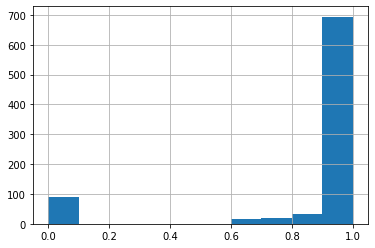

In [8]:
df['doi_match'].hist()

In [11]:
df[df['title_doi'] != ''].sort_values('doi_match').head()

,title,title_doi,url,doi,authors,authors_doi,affiliation,publisher,container,published,keywords,subject,abstract,doi_match
333,OUP accepted manuscript,A qualitative study of zoonotic risk factors a...,http://dx.doi.org/10.1093/inthealth/ihaa001,10.1093/inthealth/ihaa001,"[Li, Hong-Ying, Zhu, Guang-Jian, Zhang, Yun-Zh...","[Hong-Ying Li, Guang-Jian Zhu, Yun-Zhi Zhang, ...","[EcoHealth Alliance, 460 West 34th Street, New...",Oxford University Press (OUP),[International Health],2020-01-09T04:19:55Z,"[2019-nCoV, SARS, Zoonotic Risk, coronavirus, ...","[Public Health, Environmental and Occupational...",Background: Strategies are urgently needed to ...,0.524444
255,Homologous recombination within the spike glyc...,Cross‐species transmission of the newly identi...,http://dx.doi.org/10.1002/jmv.25682,10.1002/jmv.25682,"[Ji, Wei, Wang, Wei, Zhao, Xiaofang, Zai, Junj...","[Wei Ji, Wei Wang, Xiaofang Zhao, Junjie Zai, ...",[Department of MicrobiologyPeking University H...,Wiley,[Journal of Medical Virology],2020-01-22T12:49:42Z,"[2019-nCoV, RSCU, cross-species transmission, ...","[Virology, Infectious Diseases]",The current outbreak of viral pneumonia in the...,0.606522
433,The transmembrane serine protease inhibitors a...,The insert sequence in SARS-CoV-2 enhances spi...,http://dx.doi.org/10.1101/2020.02.08.926006,10.1101/2020.02.08.926006,"[Meng, Tong, Cao, Hao, Zhang, Hao, Kang, Zijia...","[Tong Meng, Hao Cao, Hao Zhang, Zijian Kang, D...",[],Cold Spring Harbor Laboratory,[],2020-02-12T06:09:40Z,[],[],The 2019 novel coronavirus (2019-nCoV) induces...,0.622319
267,"Structure-based drug design, virtual screening...",Structure of Mpro from COVID-19 virus and disc...,http://dx.doi.org/10.1101/2020.02.26.964882,10.1101/2020.02.26.964882,"[Jin, Zhenming, Du, Xiaoyu, Xu, Yechun, Deng, ...","[Zhenming Jin, Xiaoyu Du, Yechun Xu, Yongqiang...",[],Cold Spring Harbor Laboratory,[],2020-02-28T07:55:16Z,[],[],A coronavirus identified as 2019 novel coronav...,0.628478
404,SARS-CoV-2 sensitive to type I interferon pret...,Type I interferon susceptibility distinguishes...,http://dx.doi.org/10.1101/2020.03.07.982264,10.1101/2020.03.07.982264,"[Lokugamage, Kumari G, Schindewolf, Craig, Men...","[Kumari G. Lokugamage, Adam Hage, Maren de Vri...",[],Cold Spring Harbor Laboratory,[],2020-03-10T06:05:10Z,[],[],"SARS-CoV-2, a novel coronavirus (CoV), has rec...",0.642205


Most of the article titles seems to be matching the title in the xml file. The main reasons for the mismatch are the following:

- Response Not Found for the crossref api. 
    - One can use other end points for verifications.
- Missing doi in the xml file. 
    - One can use other fields like title and authors to verify the results.
- Change of title due to different versioning. (authors are the same)
    - 'Homologous recombination within the spike glycoprotein of the newly identified coronavirus may boost cross-species transmission from snake to human',
    - 'Cross‐species transmission of the newly identified coronavirus 2019‐nCoV'
- Changes in the title due to new results. (authors are different)
     - 'Structure-based drug design, virtual screening and high-throughput screening rapidly identify antiviral leads targeting COVID-19'
     - 'Structure of Mpro from COVID-19 virus and discovery of its inhibitors'    
     
The main focus of this analysis is to perform topic modeling on the existing abstracts. However, it is always preferred to use an api endpoint to retrieve the latest version of the publications. 

## Removing Duplicate Records

In [12]:
len(df[df['doi'].duplicated()]), len(df[df['title'].duplicated()]), len(df[df['abstract'].duplicated()])

(83, 18, 6)

There are 27 records with duplicated doi and 18 records with duplicated titles. However, there are only 6 records with duplicated abstract. Since doi is a digital unique identifier, we can safely remove records with duplicated doi (20 records). 

**Note:** we can potentially use the different (pre-print) versions of the articles to further verify the results.

In [13]:
print(len(df)) # before removing
dataset = df.drop_duplicates(subset=['title', 'abstract'], keep='last').reset_index(drop=True)
print(len(dataset)) # after removing

851
846


## Exploratory Analysis

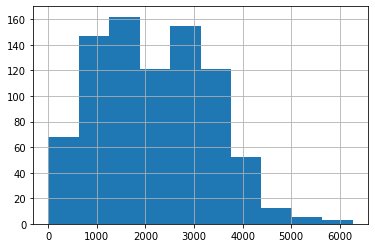

In [14]:
dataset['len'] = dataset['abstract'].apply(lambda x: len(x))
dataset['len'].hist()

In [15]:
# Top Publishers

dataset.groupby('publisher').size().sort_values(ascending=False)[:20]

publisher
Cold Spring Harbor Laboratory                                602
                                                              89
Elsevier BV                                                   29
MDPI AG                                                       28
Wiley                                                         14
Oxford University Press (OUP)                                  9
Springer Science and Business Media LLC                        7
Informa UK Limited                                             7
F1000 Research Ltd                                             6
Centers for Disease Control and Prevention (CDC)               4
European Centre for Disease Control and Prevention (ECDC)      4
Cambridge University Press (CUP)                               4
Radiological Society of North America (RSNA)                   4
Massachusetts Medical Society                                  3
Australian Government Department of Health                     3
Centers for Dis

In [16]:
from collections import Counter
from  itertools import chain

# Top Authors
pd.Series(Counter(chain(*dataset['authors']))).sort_values(ascending=False)[:20].reset_index()

,index,0
0,"Nishiura, Hiroshi",15
1,"Liu, Lei",14
2,"Chowell, Gerardo",13
3,"Yang, Yichi",10
4,"Kinoshita, Ryo",10
5,"Yu, Hongjie",10
6,"Zhao, Shi",10
7,"Wang, Jing",9
8,"Hayashi, Katsuma",9
9,"Lipsitch, Marc",9


In [17]:
dataset['date'] = pd.to_datetime(dataset['published']).dt.date

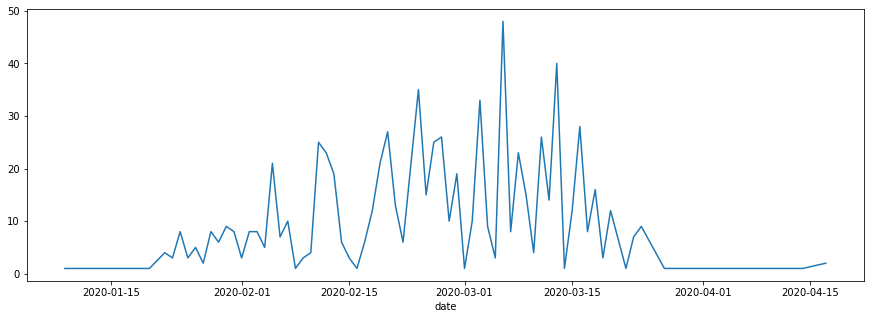

In [18]:
# Number of papers over time

dataset.groupby('date').size().plot(figsize=(15,5))

In [20]:
dataset['date'].describe()

count            757
unique            68
top       2020-03-06
freq              48
Name: date, dtype: object

The dataset seems to contain artilcles from a four month period, starting from '2020-01-09' to '2020-04-17' with a peak around '2020-03-06'.

In [21]:
dataset.to_pickle('./dataset_covid.pkl')